# Use ButcherPy's NMF algorithm

After cloning the ButcherPy Github repository, make sure to run this notebook in an environment that has installed all necessary packages: <br>
pip install torch <br>
pip install anndata <br>
pip install scikit-learn-extra <br>
pip install seaborn <br>
pip install rds2py <br>

This vignette shows the basic workflow to use NMF from the ButcherPy package. The package is compatible to various datatypes, which are all presented here. We specifically show an example with the RData files on bipolar disorder data provided in the GitHub repository of ButcherPy.

In [1]:
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import sys
sys.path.append("../../ButcherPy")
import src.butcherPy.multiplerun_NMF_class as multinmf
import src.butcherPy.nmf_run as nmf
from src.modules.utils import rds_to_ann

## Load Data

You can use a simple numpy array, but note that you cannot provide annotations in this way. Default annotations in the form of "Gene_x" are used for the rows and "Sample_x" are used for the columns.

In [2]:
np.random.seed(123)
# matrix with 1000 rows corresponding to 1000 genes and 6 columns corresponding to samples
test_mat = np.random.rand(1000,6)

You can use a pandas Dataframe. Make sure that the genes are stored in the rows and samples in the columns. If it is the other way around use the transpose function.

In [3]:
df = pd.DataFrame(test_mat)
# df = df.tranpose()
df.index = ["Gene_" + str(i+1) for i in range(df.shape[0])]
df.columns = ["Sample_" + str(i+1) for i in range(df.shape[1])]

You can use an AnnData object with gene annotations in the "var_names" variable and sample annotations in the "obs_names" variable.

In [4]:
path_to_adata = "your_path.h5ad"
adata = sc.read_h5ad(path_to_adata)

You can use RData that will be transformed to AnnData for you. Here the package provides a few options:
1. Only provide a path to RData file that stores the matrix. In this case the default annoations are created the same way, as if using a numpy array. Be aware, that the matrix should have the form (samples, genes), meaning that the genes are stored in the columns. Thus, make sure to provide a boolean value for gene_columns; True if the genes are stored in the columns and False if not.
2. Provide paths to RData files containing the matrix, the gene and sample annotations. You have to provide the gene_columns variable here as well. But if you are unsure about the stored format, this option provides you with warnings, in case the matrix and annotation dimensions do not coincide. Additionally, the function also tells you which attributes are used for annotations, and gives you options to change these. You can also save all information given by the path to the sample annotations (not only the chosen sample annotation names) by setting the parameter extra_meta to True.
3. Provide path to RData file containing the matrix, and self extracted annotations. This is the best option, if the function fails with the provided data files to the gene and sample annotations.

In [5]:
# 1. only path to RData file
path_to_rdata = "../data/GSE_bpd/GSE53987_2.rds"
format = False # change this parameter according to the description provided above
adata = rds_to_ann(path_to_rdsmatrix=path_to_rdata, gene_columns=format)

The rds file stores a dense matrix


/home/bq_lboland/ButcherPy/vignettes/../../ButcherPy/src/modules/utils.py:116: UserWarning: You have not provided an annotation for the genes, by default the columns are numerated.
  warnings.warn("You have not provided an annotation for the genes, by default the columns are numerated.")
/home/bq_lboland/ButcherPy/vignettes/../../ButcherPy/src/modules/utils.py:146: UserWarning: You have not provided an annotation for the samples, by default the rows are numerated.
  warnings.warn("You have not provided an annotation for the samples, by default the rows are numerated.")


In [6]:
# 2. path to RData files for matrix, gene and sample annotations
path_to_rdata = "../data/GSE_bpd/GSE53987_2.rds"
path_to_genes = "../data/GSE_bpd/GSE53987_2_annots.rds"
path_to_samples = "../data/GSE_bpd/GSE53987_2_metadata.rds"
adata = rds_to_ann(path_to_rdata, path_to_rdsannot=path_to_genes, path_to_rdsmeta=path_to_samples, extra_metas=True, gene_columns=format)

The rds file stores a dense matrix



Your gene annotation file stores ID, Gene symbol, Gene ID. Due to the provided gene_index parameter of 0, ID is used for the annotation. If this is not the desired gene annotation, you can change the index parameter, with these options:
0 (corresponding to ID), 1 (corresponding to Gene symbol), 2 (corresponding to Gene ID)

Your sample annotation file stores GROUP, tissue, age, gender, race, pmi, ph, rin. Due to the provided sample_index parameter of 0, GROUP is used for the annotation. If this is not the desired sample annotation, you can change the index parameter, with these options:
0 (corresponding to GROUP), 1 (corresponding to tissue), 2 (corresponding to age), 3 (corresponding to gender), 4 (corresponding to race), 5 (corresponding to pmi), 6 (corresponding to ph), 7 (corresponding to rin)


The output provides you with the information which elements are used for annotations, if you are not satisfied with those you can choose the ones you want to use in the next code and run the rds_to_ann function again.

In [7]:
gene_idx = 1
sample_idx = 1
adata = rds_to_ann(path_to_rdata, path_to_rdsannot=path_to_genes, path_to_rdsmeta=path_to_samples, gene_index=gene_idx, sample_index=sample_idx, extra_metas=True, gene_columns=format)

The rds file stores a dense matrix

Your gene annotation file stores ID, Gene symbol, Gene ID. Due to the provided gene_index parameter of 1, Gene symbol is used for the annotation. If this is not the desired gene annotation, you can change the index parameter, with these options:
0 (corresponding to ID), 1 (corresponding to Gene symbol), 2 (corresponding to Gene ID)

Your sample annotation file stores GROUP, tissue, age, gender, race, pmi, ph, rin. Due to the provided sample_index parameter of 1, tissue is used for the annotation. If this is not the desired sample annotation, you can change the index parameter, with these options:
0 (corresponding to GROUP), 1 (corresponding to tissue), 2 (corresponding to age), 3 (corresponding to gender), 4 (corresponding to race), 5 (corresponding to pmi), 6 (corresponding to ph), 7 (corresponding to rin)


Now the Gene symbol is used for gene annotation and the tissue is used for sample annotations.

In [8]:
# 3. path to RData file containing matrix and self extracted annotations
path_to_rdata = "data/GSE_bpd/GSE53987_2.rds"
gene_annot = [] # list of gene annotations, need to have length compatible with provided matrix, or default annotation is used
sample_annot = [] # list of sample annotations, need to have length compatible with provided matrix, or default annotation is used
adata = rds_to_ann(path_to_rdata, gene_annot=gene_annot, sample_annot=sample_annot, gene_columns=format)

## Define the remaining parameters for the NMF run

In [9]:
test_ranks = [3, 4]
tn_initializations = 10
titerations = 100
tseed = 123
tstop_threshold = 40
tnthreads = 1

## Perform the NMF run

In [10]:
nmf_multiple = nmf.multiple_rank_NMF(adata, # or test_mat or df
                                     test_ranks, 
                                     tn_initializations, 
                                     titerations, 
                                     tseed, 
                                     tstop_threshold, 
                                     tnthreads)

Factorization rank:  3


NMF converges after 100, 100, 100, 100, 100, 100, 100, 100, 100, 100 iterations for the different initializations.
Factorization rank:  4


NMF converges after 100, 100, 100, 100, 100, 100, 100, 100, 100, 100 iterations for the different initializations.


## Working with the NMF results

There are several functions in the multiplerun_NMF_class to work with the results of the NMF run, in the following some useful examples are presented.

In [11]:
# First, metrics for the different runs are calculated
nmf_multiple.compute_OptKStats_NMF()
# Next, the metrics are compared in a way to find the best suited factorisation rank under the computed ones
nmf_multiple.compute_OptK()

/home/bq_lboland/ButcherPy/vignettes/../../ButcherPy/src/butcherPy/multiplerun_NMF_class.py:352: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  my_hclust = linkage(dist_matrix, method="average")


/home/bq_lboland/ButcherPy/vignettes/../../ButcherPy/src/butcherPy/multiplerun_NMF_class.py:352: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  my_hclust = linkage(dist_matrix, method="average")


The optimal factorisation rank from the given ranks is  4


[4]

Start feature contribution determination for rank 3


Start feature contribution determination for rank 4


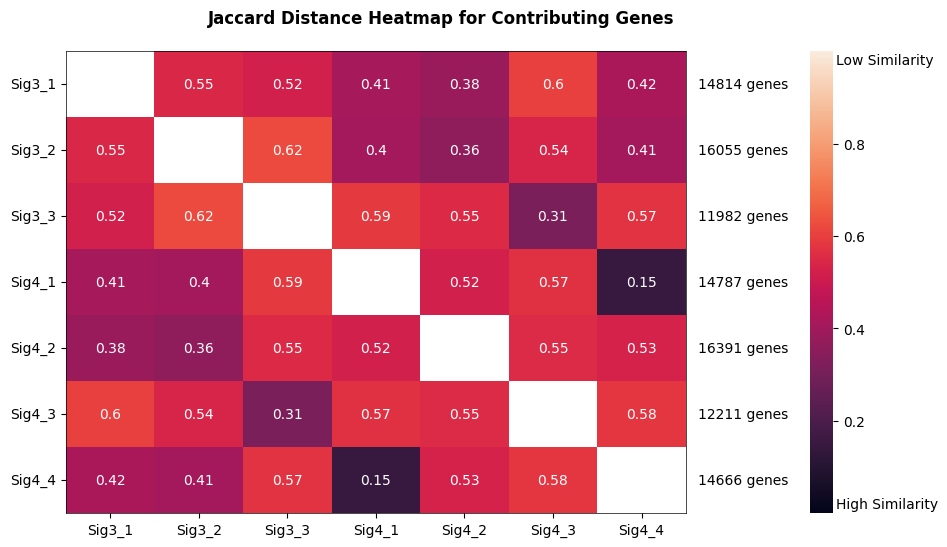

In [12]:
# Check which feature contributes to which signature
nmf_multiple.WcomputeFeatureStats()
# Create a heatmap showing the jaccard distance between the sets of contributing genes of all signatures
your_path = "SignatureComparison.png"
nmf_multiple.signature_heatmap(your_path)